In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
pwd

'/Users/sebas/projects/metabolomics/notebooks/ordinal_classification'

In [3]:
import os 
os.chdir('/Users/sebas/projects/metabolomics/')
# Set the environment variable
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [4]:
import dill
import torch
from torch.utils.data import DataLoader
import lightning.pytorch as pl

from pytorch_lightning.callbacks import ProgressBar
from src.train_utils import TrainUtils
import matplotlib.pyplot as plt
from src.config import Config
import numpy as np
from torch.utils.data import DataLoader, WeightedRandomSampler
import os
from src.parser import Parser
import random
from src.weight_sampling import WeightSampling
from src.losscallback import LossCallback
from src.molecular_pairs_set import MolecularPairsSet
from src.sanity_checks import SanityChecks
from src.transformers.postprocessing import Postprocessing
from scipy.stats import spearmanr
import seaborn as sns
from src.ordinal_classification.load_data_ordinal import LoadDataOrdinal
from src.ordinal_classification.embedder_ordinal import EmbedderOrdinal
from sklearn.metrics import confusion_matrix


In [5]:
## Replicate standard regression training DONE


In [6]:
## Discretize the range

In [7]:
## Train a classification model

In [8]:
## Use gumbel softmax function

In [9]:
config = Config()

In [56]:
config.USE_GUMBEL=False

In [57]:
config.N_CLASSES=6

In [12]:
config.D_MODEL=128

In [13]:
config.bins_uniformise_INFERENCE=config.N_CLASSES-1

In [14]:
config.use_uniform_data_INFERENCE = True

## Replicate standard regression training

In [15]:
data_folder= '/Users/sebas/projects/data/'
dataset_path= data_folder +'merged_gnps_nist_20240311_unique_smiles_1_million.pkl'

In [16]:
config.dataset_path=dataset_path
config.CHECKPOINT_DIR = data_folder + 'temp_training/'

In [17]:
# parameters
dataset_path = config.dataset_path
epochs = config.epochs
bins_uniformise_inference = config.bins_uniformise_INFERENCE
enable_progress_bar = config.enable_progress_bar
fig_path = config.CHECKPOINT_DIR + f"scatter_plot_{config.MODEL_CODE}.png"
model_code = config.MODEL_CODE

In [18]:
print("loading file")
# Load the dataset from the pickle file
with open(dataset_path, "rb") as file:
    dataset = dill.load(file)

molecule_pairs_train = dataset["molecule_pairs_train"]
molecule_pairs_val = dataset["molecule_pairs_val"]
molecule_pairs_test = dataset["molecule_pairs_test"]
uniformed_molecule_pairs_test = dataset["uniformed_molecule_pairs_test"]

loading file


In [19]:

print(f"Number of pairs for train: {len(molecule_pairs_train)}")
print(f"Number of pairs for val: {len(molecule_pairs_val)}")
print(f"Number of pairs for test: {len(molecule_pairs_test)}")
print(f"Number of pairs for uniform test: {len(uniformed_molecule_pairs_test)}")

Number of pairs for train: 955957
Number of pairs for val: 586692
Number of pairs for test: 586781
Number of pairs for uniform test: 40940


In [20]:
## CALCULATION OF WEIGHTS
train_binned_list, _ = TrainUtils.divide_data_into_bins(
    molecule_pairs_train,
    config.N_CLASSES-1,
    bin_sim_1=True, 
)
#train_binned_list, _ = TrainUtils.divide_data_into_bins(
#    molecule_pairs_train,
#    config.N_CLASSES-1,
#    bin_sim_1=False, 
#)


In [21]:
[t.indexes_tani.shape for t in train_binned_list]

[(299985, 3), (166229, 3), (316846, 3), (115705, 3), (25305, 3), (31887, 3)]

In [22]:
weights, range_weights = WeightSampling.compute_weights_categories(train_binned_list)
#weights, range_weights = WeightSampling.compute_weights(train_binned_list)

In [23]:
weights

array([0.03622318, 0.06537013, 0.03429556, 0.0939148 , 0.42941758,
       0.34077874])

In [24]:
range_weights

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [25]:
weights_tr = WeightSampling.compute_sample_weights_categories(molecule_pairs_train, weights)
weights_val = WeightSampling.compute_sample_weights_categories(molecule_pairs_val, weights)
#weights_tr = WeightSampling.compute_sample_weights(molecule_pairs_train, weights)
#weights_val = WeightSampling.compute_sample_weights(molecule_pairs_val, weights)

In [26]:
dataset_train = LoadDataOrdinal.from_molecule_pairs_to_dataset(molecule_pairs_train, training=True)
# dataset_test = LoadData.from_molecule_pairs_to_dataset(m_test)
dataset_val = LoadDataOrdinal.from_molecule_pairs_to_dataset(molecule_pairs_val)

Preprocessing all the data ...


261349it [00:07, 37027.25it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries
Preprocessing all the data ...


31318it [00:00, 46228.01it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


In [27]:
# delete variables that are not useful for memory savings
del molecule_pairs_train
del molecule_pairs_val
del molecule_pairs_test
del uniformed_molecule_pairs_test

In [28]:
class CustomWeightedRandomSampler(WeightedRandomSampler):
    """WeightedRandomSampler except allows for more than 2^24 samples to be sampled"""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __iter__(self):
        rand_tensor = np.random.choice(
            range(0, len(self.weights)),
            size=self.num_samples,
            p=self.weights.numpy() / torch.sum(self.weights).numpy(),
            replace=self.replacement,
        )
        rand_tensor = torch.from_numpy(rand_tensor)
        return iter(rand_tensor.tolist())


train_sampler = CustomWeightedRandomSampler(
    weights=weights_tr, num_samples=len(dataset_train), replacement=True
)
val_sampler = CustomWeightedRandomSampler(
    weights=weights_val, num_samples=len(dataset_val), replacement=True
)

In [29]:
print("Creating train data loader")
dataloader_train = DataLoader(
    dataset_train, batch_size=config.BATCH_SIZE, sampler=train_sampler, num_workers=10
)

Creating train data loader


In [30]:
def worker_init_fn(
    worker_id,
):  # ensure the dataloader for validation is the same for every epoch
    seed = 42
    torch.manual_seed(seed)
    # Set the same seed for reproducibility in NumPy and Python's random module
    np.random.seed(seed)
    random.seed(seed)


print("Creating val data loader")
dataloader_val = DataLoader(
    dataset_val,
    batch_size=config.BATCH_SIZE,
    sampler=val_sampler,
    worker_init_fn=worker_init_fn,
    num_workers=0,
)


Creating val data loader


In [63]:
# Define the ModelCheckpoint callback
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=config.CHECKPOINT_DIR,
    filename="best_model",
    monitor="validation_loss_epoch",
    mode="min",
    save_top_k=1,
)

checkpoint_n_steps_callback = pl.callbacks.ModelCheckpoint(
    dirpath=config.CHECKPOINT_DIR,
    filename="best_model_n_steps",
    every_n_train_steps=100,
    save_last=True,
    save_top_k=1,
)


# checkpoint_callback = SaveBestModelCallback(file_path=config.best_model_path)
progress_bar_callback = ProgressBar()

# loss callback
losscallback = LossCallback(file_path=config.CHECKPOINT_DIR + f"loss.png")
print("define model")


define model


In [64]:
config.USE_GUMBEL

False

In [65]:
model = EmbedderOrdinal(
    d_model=int(config.D_MODEL),
    n_layers=int(config.N_LAYERS),
    n_classes=config.N_CLASSES,
    weights=None,
    lr=config.LR,
    use_cosine_distance=config.use_cosine_distance,
    use_gumbel = config.USE_GUMBEL,
)

Using cosine library from Pytorch?: True


In [66]:
trainer = pl.Trainer(
    max_steps=100,
    #max_epochs=1,
    callbacks=[checkpoint_callback, checkpoint_n_steps_callback, losscallback],
    enable_progress_bar=enable_progress_bar,
    # val_check_interval= config.validate_after_ratio,
)
# trainer = pl.Trainer(max_steps=100,  callbacks=[checkpoint_callback, losscallback], enable_progress_bar=enable_progress_bar)
trainer.fit(
    model=model,
    train_dataloaders=(dataloader_train),
    val_dataloaders=dataloader_val,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                    | Type                             | Params
------------------------------------------------------------------------------
0  | linear                  | Linear                           | 16.5 K
1  | linear_regression       | Linear                           | 129   
2  | fixed_linear_regression | FixedLinearRegression            | 129   
3  | relu                    | ReLU                             | 0     
4  | spectrum_encoder        | SpectrumTransformerEncoderCustom | 1.7 M 
5  | regression_loss         | MSELoss                          | 0     
6  | dropout                 | Dropout                          | 0     
7  | linear_cosine           | Linear                           | 16.5 K
8  | cosine_similarity       | CosineSimilarity                 | 0     
9  | classifier              | Linear  

Sanity Checking: |                                                                                            …

Train loss:
[]
Validation loss
[4.304452419281006]


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_steps=100` reached.
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1167d0860>
Traceback (most recent call last):
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/multiprocessing/connect

Error in callback <function flush_figures at 0x2e15c28e0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

## Inference

In [67]:
#best_model_path = model_path = data_folder + 'best_model_exhaustive_sampled_128n_20240618.ckpt'
#best_model_path = config.CHECKPOINT_DIR + f"best_model_n_steps-v9.ckpt"
best_model_path = config.CHECKPOINT_DIR + f"last.ckpt"

In [68]:
molecule_pairs_test = dataset["molecule_pairs_test"]
print(f"Number of molecule pairs: {len(molecule_pairs_test)}")
print("Uniformize the data")
uniformed_molecule_pairs_test, _ = TrainUtils.uniformise(
    molecule_pairs_test,
    number_bins=bins_uniformise_inference,
    return_binned_list=True,
    bin_sim_1=True,
    #bin_sim_1=False,
)  # do not treat sim==1 as another bin

Number of molecule pairs: 586781
Uniformize the data


In [69]:
# dataset_train = LoadData.from_molecule_pairs_to_dataset(m_train)
dataset_test = LoadDataOrdinal.from_molecule_pairs_to_dataset(uniformed_molecule_pairs_test)
dataloader_test = DataLoader(dataset_test, batch_size=config.BATCH_SIZE, shuffle=False)

Preprocessing all the data ...


33719it [00:00, 46413.38it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


In [70]:
# Testinbest_model = Embedder.load_from_checkpoint(checkpoint_callback.best_model_path, d_model=64, n_layers=2)
trainer = pl.Trainer(max_epochs=2, enable_progress_bar=enable_progress_bar)
best_model = EmbedderOrdinal.load_from_checkpoint(
    best_model_path,
    d_model=int(config.D_MODEL),
    n_layers=int(config.N_LAYERS),
    n_classes=config.N_CLASSES,
    use_gumbel=config.USE_GUMBEL,
    use_element_wise=True,
    use_cosine_distance=config.use_cosine_distance,
    
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Using cosine library from Pytorch?: True


## Postprocessing

In [71]:
pred_test = trainer.predict(
    best_model,
    dataloader_test,
)
similarities_test = Postprocessing.get_similarities(dataloader_test)


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

In [72]:
index=10
print(pred_test[0][index])
print(similarities_test[index])

tensor([1., 0., 0., 0., 0., 0.])
0.0


In [73]:
pred_test[0][6]

tensor([1., 0., 0., 0., 0., 0.])

In [74]:
np.argwhere(pred_test[0][0]>0.1)[0]

tensor([1])

In [75]:
np.argwhere(pred_test[0][0]>0.9)[0].numel()

1

In [76]:
def which_index(p, threshold=0.999):
    result= np.argwhere(p>threshold)[0]
     #
    if result.numel()==0:
        #return np.argmax(p)
        return np.nan
    else:
        return result[-1]
    #return np.argmax(p)

In [77]:
# flat the results
flat_pred_test = []
for pred in pred_test:
    flat_pred_test = flat_pred_test + [which_index(p) for p in pred]
flat_pred_test=np.array( flat_pred_test)

In [78]:
#list(pred_test)

In [79]:
flat_pred_test[0]

1

## Corr. Analysis

In [80]:
similarities_test=np.array(similarities_test)
flat_pred_test=np.array(flat_pred_test)

In [81]:
len(similarities_test)

16002

In [82]:
similarities_test_cleaned= similarities_test[~np.isnan(flat_pred_test)]
flat_pred_test_cleaned= flat_pred_test[~np.isnan(flat_pred_test)]

In [83]:
len(similarities_test_cleaned)

16002

In [84]:

corr_model, p_value_model= spearmanr(similarities_test_cleaned, flat_pred_test_cleaned)


In [85]:
corr_model

-0.007908620025526085

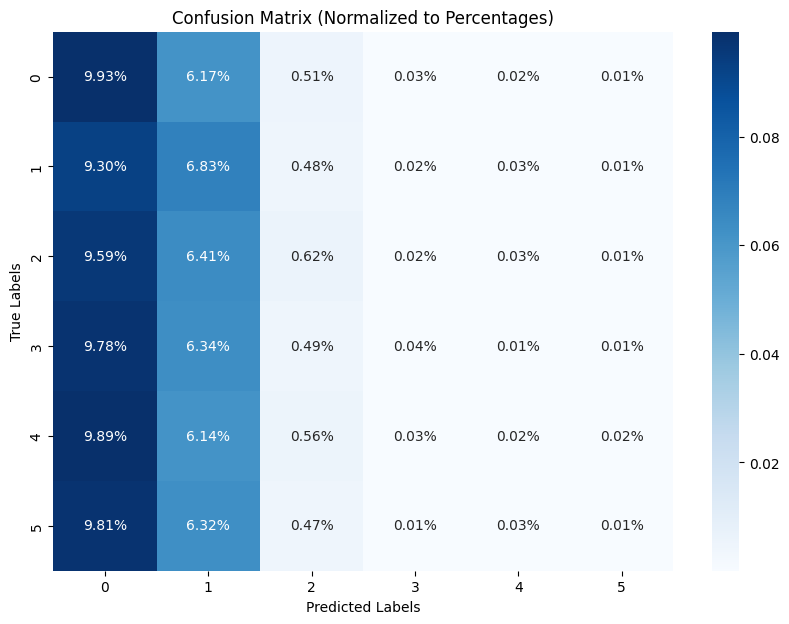

In [86]:
# Compute the confusion matrix
cm = confusion_matrix(similarities_test_cleaned, flat_pred_test_cleaned)
# Normalize the confusion matrix by the number of true instances for each class
cm_normalized = cm.astype('float') / cm.sum()
# Plot the confusion matrix with percentages
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Normalized to Percentages)')
plt.show()

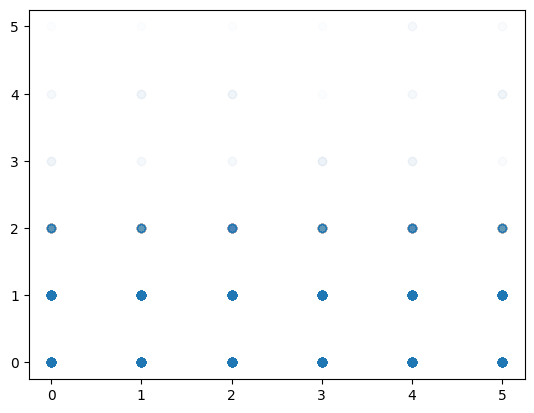

In [87]:
plt.scatter(similarities_test, flat_pred_test, alpha=0.01)

##### 